In [23]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib qt

# Create Data

In [7]:
# data to plot
x = np.arange(-30, 30, 0.1)
def f(x): return np.sin(x) * 20
def l(x): return x
def g(x): return -x

value = lambda x: np.array([[f(x), f(x), f(x)],
                            [l(x), l(x), l(x)],
                            [g(x), g(x), g(x)]])

def yield_value():
    for i in x:
        yield value(i)

# plot single

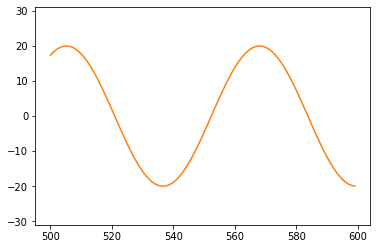

In [16]:
# plot single fig first
%matplotlib qt

buffer = []
interval = 100
i = 0

for i in range(len(x)):
    buffer.append(value(x[i]))
    plt.ylim((-31, 31))

    if i > interval:
        interval_buf = np.array(buffer[i - interval:i])
        x_axis = range(i - interval + 1, i + 1)
        plt.plot(x_axis, interval_buf[:, 0, 0], 'C1')
    else:
        interval_buf = np.array(buffer)
        x_axis = range(i + 1)
        plt.plot(x_axis, interval_buf[:, 0, 0], 'C1')
    plt.pause(1e-32)
    plt.clf()
    
%matplotlib inline
plt.ylim((-31, 31))
plt.plot(x_axis, interval_buf[:, 0, 0], 'C1')

# test subplot speed

very slow

In [ ]:
def plot_buffer(buffer):
    def subplot_(values, c):
        fig.add_subplot(3, 3, c)
        plt.ylim(-31, 31)
        # plt.title(title)
        plt.plot(values)

    interval_buf = np.array(buffer)
    x_axis = range(1, len(buffer) + 1)    

    fig = plt.figure(figsize=(12, 12))

    c = 1
    for j in range(3):
        for i in range(3):
            subplot_(interval_buf[:, j, i], c) 
            c += 1
    plt.show()    
%timeit plot_buffer(buffer)

In [ ]:
def plot_buffer(buffer):
    fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
    
    interval_buf = np.array(buffer)
    x_axis = range(1, len(buffer) + 1)    

    for j in range(3):
        for i in range(3):
            axarr[i][j].set_ylim(-31, 31)
            axarr[i][j].plot(x_axis, interval_buf[:, i, j])
    plt.show()
    
%timeit plot_buffer(buffer)

# realtime

## single fig

In [3]:
%matplotlib qt

In [15]:
def plot_wrap(mode='draw_artist', show_fps=False):
    interval = 100
    buffer = np.zeros((interval, 3, 3)).tolist()

    # yield value
    worker = yield_value()

    # create fig
    fig, axarr = plt.subplots()
    axarr.set_ylim(-31, 31)
    x_axis = range(interval)

    # create Line2D object
    interval_buf = np.array(buffer)
    lines = []
    lines.append(axarr.plot(x_axis, interval_buf[:interval, 0, 0], 'C0')[0])
    fig.canvas.draw()
    
    start_time = time.time()
    for i, v in enumerate(worker, 1):

        buffer.append(v.tolist())
        interval_buf = np.array(buffer)
        lines[0].set_ydata(interval_buf[i:i + interval, 0, 0])
        
        if mode == 'draw_artist': 
            axarr.draw_artist(axarr.patch)
            axarr.draw_artist(lines[0])
            fig.canvas.update()
            fig.canvas.flush_events()

        elif mode == 'canvas_flush':
            fig.canvas.draw()
            fig.canvas.flush_events()       
        elif mode == 'pause':
            plt.pause(1e-16)
        else:
            raise NotImplementedError(f'doesn\'t support mode: {mode}')
        
    if show_fps:
        end_time = time.time()
        dur = end_time - start_time
        print(f'{dur / i * 1000:.4f} ms per frame')
        print(f'fps = {i/dur}')

### repeatly plot every frame(normal)

need plt.pause() to prevent crash

In [23]:
interval = 100
buffer = np.zeros((interval, 3, 3)).tolist()

# yield value
worker = yield_value()

# create fig
fig, axarr = plt.subplots()
axarr.set_ylim(-31, 31)
x_axis = range(interval)

# create Line2D object
interval_buf = np.array(buffer)
#lines = []
#lines.append(axarr.plot(x_axis, interval_buf[:interval, 0, 0], 'C0')[0])
axarr.plot(x_axis, interval_buf[:interval, 0, 0], 'C0')
plt.show()

start_time = time.time()
for i, v in enumerate(worker, 1):
    
    buffer.append(v.tolist())
    interval_buf = np.array(buffer)
    #lines[0].set_data(x_axis, interval_buf[i:i+interval, 0, 0])
    x_axis = range(interval+i, interval*2+i)
    axarr.plot(x_axis, interval_buf[i:i+interval, 0, 0], 'C0')
    plt.pause(1e-16)
    
end_time = time.time()
dur = end_time - start_time
print(f'{dur / i * 1000:.4f} ms per frame')
print(f'fps = {i/dur}')

47.9627 ms per frame
fps = 20.849546504279328


### only modify the fig data

- To speed up, only modify the fig data instead of plot again.

In [5]:
plot_wrap('pause', show_fps=True)

13.2233 ms per frame
fps = 75.62407880777683


In [33]:
%timeit plot_wrap('pause', show_fps=True)

13.4346 ms per frame
fps = 74.43483801939004
25.3424 ms per frame
fps = 39.459496760421025
30.7488 ms per frame
fps = 32.52163884618683
34.7343 ms per frame
fps = 28.789952773896914
38.1473 ms per frame
fps = 26.21417171825462
42.6017 ms per frame
fps = 23.47326191526815
47.7375 ms per frame
fps = 20.947891476677356
52.6902 ms per frame
fps = 18.978846311710388
23.3 s ± 5.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### canvas flush_events

plt.pause() internally calls:
         
         fig.canvas.draw()
         plt.show()
         fig.canvas.start_event_loop()
just remove plt.show()

In [7]:
plot_wrap('canvas_flush', show_fps=True)

14.6377 ms per frame
fps = 68.31659574985603


In [26]:
%timeit plot_wrap('canvas_flush', show_fps=True)

14.1237 ms per frame
fps = 70.8027511475494
13.9946 ms per frame
fps = 71.45609464185428
14.0147 ms per frame
fps = 71.35352134755722
14.0296 ms per frame
fps = 71.27761818137479
14.0119 ms per frame
fps = 71.36810691099993
14.0311 ms per frame
fps = 71.27021395968563
14.0534 ms per frame
fps = 71.15712973215116
14.0618 ms per frame
fps = 71.11474226038231
8.45 s ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### draw_artist

only draw the part that actually change

In [8]:
plot_wrap('draw_artist', show_fps=True)

3.0515 ms per frame
fps = 327.70782102855605


In [6]:
%timeit plot_wrap('draw_artist', show_fps=True)

4.0639 ms per frame
fps = 246.0717228895824
3.9302 ms per frame
fps = 254.440804639538
4.2200 ms per frame
fps = 236.96842514425268
4.0850 ms per frame
fps = 244.79673441245941
3.9992 ms per frame
fps = 250.0500928379314
4.0551 ms per frame
fps = 246.60058529587425
3.8517 ms per frame
fps = 259.6279348653889
3.9009 ms per frame
fps = 256.35118422423784
2.45 s ± 70.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## subplot

In [21]:
def plot_wrap_multi(mode='draw_artist', show_fps=False):
    interval = 100
    buffer = np.zeros((interval, 3, 3)).tolist()

    # yield value
    worker = yield_value()

    # create fig
    fig, axarr = plt.subplots(3, 3, figsize=(9, 9))
    x_axis = range(interval)

    interval_buf = np.array(buffer)

    # create Line2D object
    lines = []
    for j in range(3):
        for i in range(3):
            axarr[i][j].set_ylim(-31, 31)
            lines.append(axarr[i][j].plot(x_axis, interval_buf[:interval, i, j], 'C0')[0])
            fig.canvas.draw()

    start_time = time.time()
    for idx, v in enumerate(worker, 1):

        buffer.append(v.tolist())
        interval_buf = np.array(buffer)
        
        if mode == 'draw_artist': 
            count = 0
            for j in range(3):
                for i in range(3):
                    lines[count].set_ydata(interval_buf[idx:idx + interval, i, j])
                    axarr[i][j].draw_artist(axarr[i][j].patch)
                    axarr[i][j].draw_artist(lines[count])
                    count += 1

            fig.canvas.update()
            fig.canvas.flush_events()
            
        else:
            count = 0
            for j in range(3):
                for i in range(3):
                    lines[count].set_ydata(interval_buf[idx:idx + interval, i, j])
                    count += 1            
            
            if mode == 'canvas_flush':
                fig.canvas.draw()
                fig.canvas.flush_events()       
            elif mode == 'pause':
                plt.pause(1e-16)
            else:
                raise NotImplementedError(f'doesn\'t support mode: {mode}')
        
    if show_fps:
        end_time = time.time()
        dur = end_time - start_time
        print(f'{dur / idx * 1000:.4f} ms per frame')
        print(f'fps = {idx / dur}')

### only modify the fig data

In [24]:
# still vary slow
plot_wrap_multi('pause', show_fps=True)

92.5300 ms per frame
fps = 10.807300840990044


### canvas flush_events

86.3457 ms per frame
fps = 11.58135875829515


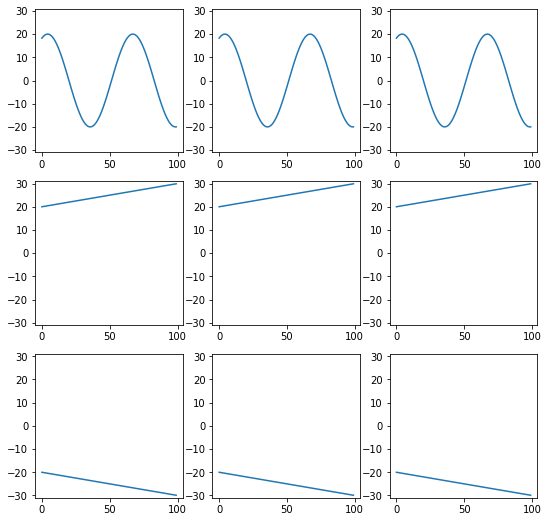

In [17]:
# still vary slow
plot_wrap_multi('canvas_flush', show_fps=True)

### draw_artist

In [14]:
plot_wrap_multi('draw_artist', show_fps=True)

9.2473 ms per frame
fps = 108.13972630394127


In [25]:
%timeit plot_wrap_multi('draw_artist', show_fps=True)

9.1497 ms per frame
fps = 109.29334319583162
9.2143 ms per frame
fps = 108.52683345370153
9.1992 ms per frame
fps = 108.70539974070519
9.1562 ms per frame
fps = 109.2154512257986
9.1419 ms per frame
fps = 109.38646871312565
9.1523 ms per frame
fps = 109.26174044411131
9.0461 ms per frame
fps = 110.54516242490675
9.0401 ms per frame
fps = 110.61837448840951
6.4 s ± 39.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
